# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

Single transfer (2x processes communicate):
- pingpong

Parallel-transfer tests (more than 2 processes communicate):
- uniband: processes communicate in pairs split between 1st and 2nd half of ranks
- biband: As for uniband but communication initiated in both directions

All tests measure latency and bandwidth for a range of message sizes.


In [5]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size - 2x processes

The plots below show results from most-recent run of each 2x process test for each system/partition/environment combination.

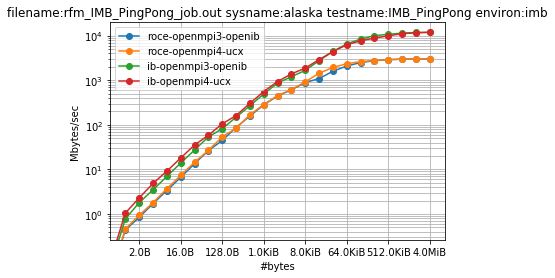

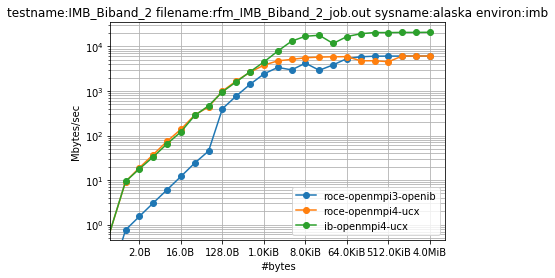

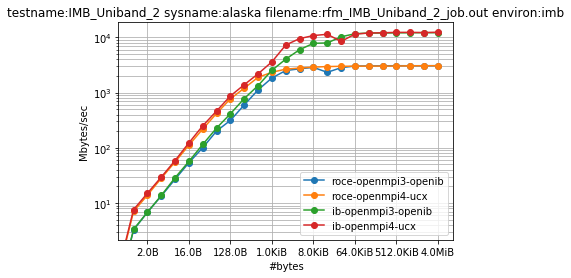

In [6]:
for test in ['IMB_PingPong', 'IMB_Biband_2', 'IMB_Uniband_2']:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    common, meta_diffs = modules.utils.diff_dicts([modules.utils.parse_path_metadata(p) for p in paths], ignore=['path'])
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.imb.read_imb_out(path)
        label = '-'.join(meta_diffs[ix].values())
        plt.plot(data['#bytes'], data['Mbytes/sec'], 'o-', data=data, label=label)
    # TODO: need to add latency plots for IMB_PingPong
        
    # format plot:
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel('Mbytes/sec')
    title = ' '.join(['%s:%s' % (k, v) for (k, v) in common.items()]) # TODO: improve
    ax.set_title(title)
    ax.legend()

# Max Bandwidth vs Number of Processes

The plots below are for the most-recent test on each system/partition/environment combination. They show the maximum bandwidth vs number of processes for the  parallel transfer tests.

In each case all tests were run on two nodes.

IMB_Uniband: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi3-openib-imb,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
n_procs,,,,
2,12099.41,12332.97,3062.87,3061.36
4,12382.96,12358.45,10525.37,11117.41
8,20975.17,21570.30,20351.96,19713.21
16,43628.04,42572.54,38564.13,41664.11
32,80928.56,80576.38,79515.13,74907.05
64,163330.48,117146.55,164547.87,123220.89


IMB_Biband: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
n_procs,,,
2,20890.43,6114.08,6116.64
4,20279.65,17844.11,19604.29
8,37231.78,33857.04,35811.70
16,71753.25,64572.38,74179.57
32,138988.00,125461.29,130877.21
64,261103.76,248771.29,178372.98


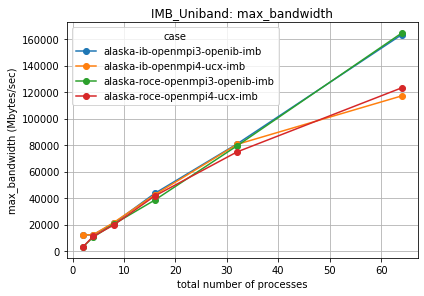

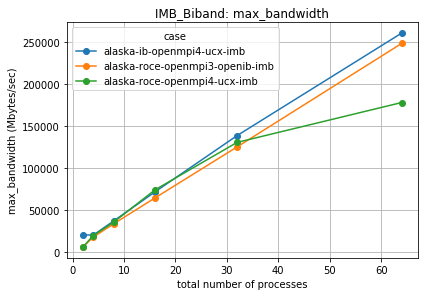

In [8]:
for test in ['IMB_Uniband', 'IMB_Biband']:
    
    # load perf records:
    perf_records = modules.utils.load_perf_logs('../perflogs', test, '.log')
    
    # calculate number of processes (=tasks):
    perf_records['n_procs'] = [int(tn.rsplit('_')[-1]) for tn in perf_records['testname']]
    
    # plot/tabulate:
    for perf_var in ['max_bandwidth']:
        perf_unit = perf_records[perf_records['perf_var'] == perf_var]['perf_unit'].iloc[0] # assumes unique
        table = modules.plots.tabulate_last_perf_vs(perf_records, 'n_procs', perf_var)
        ax = table.plot(grid=True, style='o-')
        ax.set_xlabel('total number of processes')
        ax.set_ylabel('%s (%s)' % (perf_var, perf_unit))
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        
        print('%s: %s (%s)' % (test, perf_var, perf_unit))
        display(HTML(table.to_html()))


# Performance History

The plots below show all performance variables (i.e. maximum/minimum values) for all tests in the repository, grouped by system/partition/environment.

../modules/plots.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1)
../modules/plots.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1)
../modules/plots.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, n

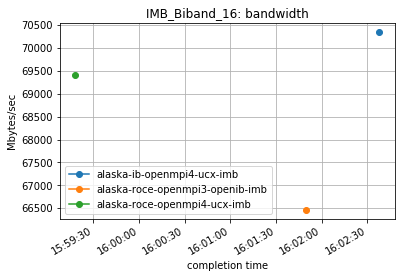

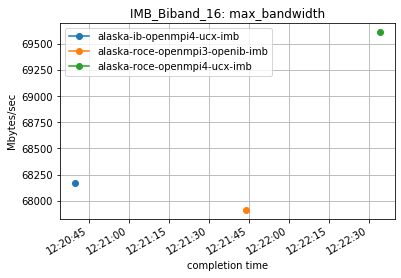

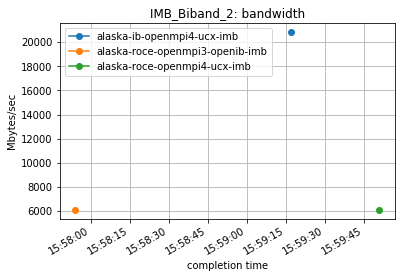

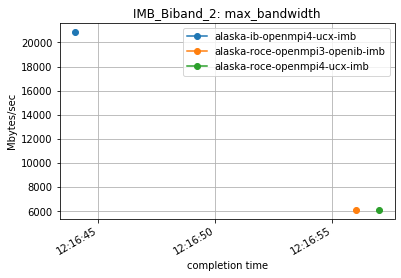

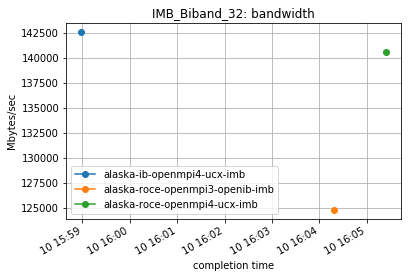

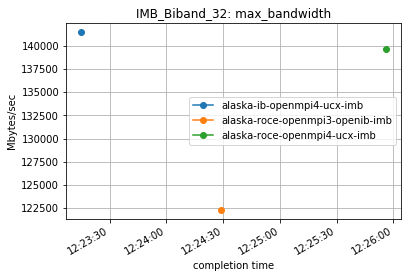

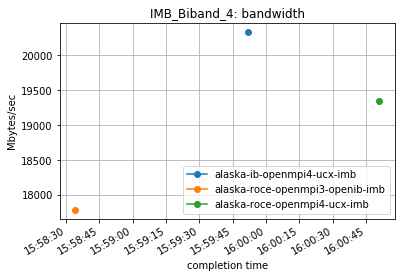

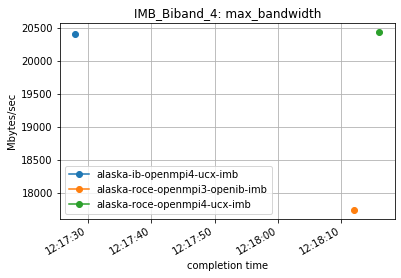

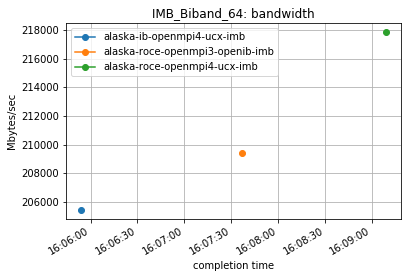

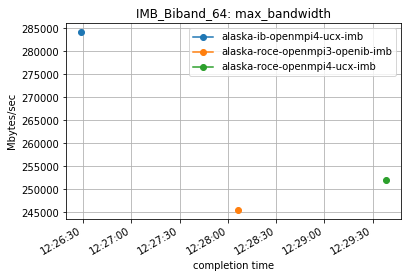

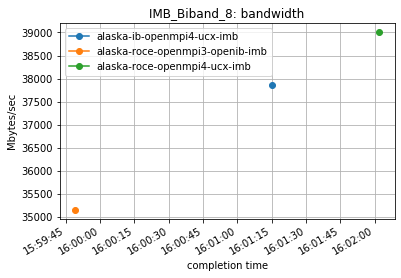

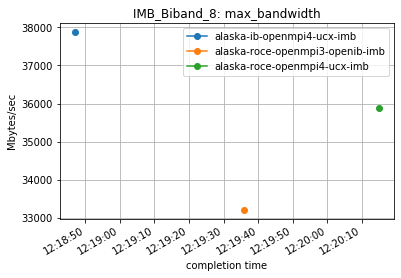

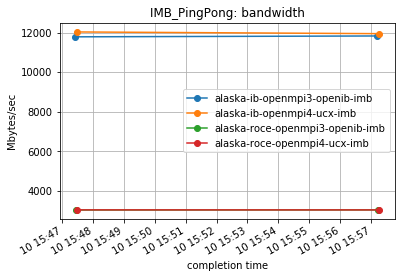

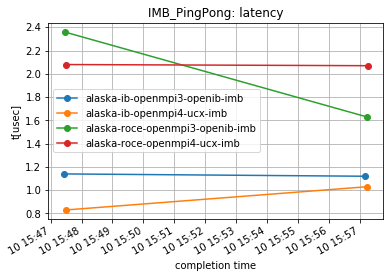

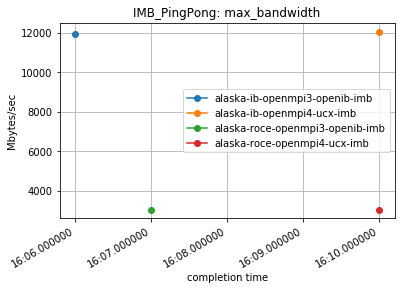

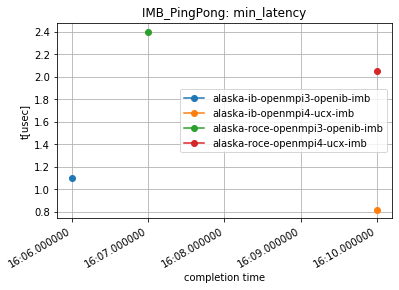

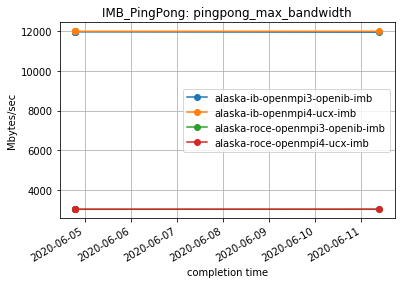

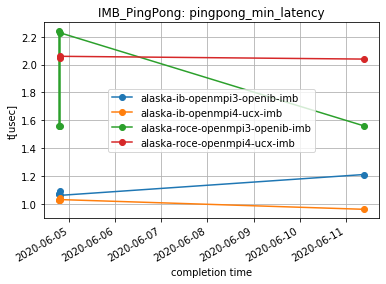

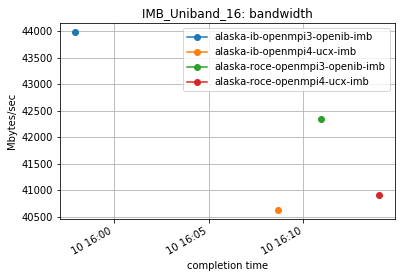

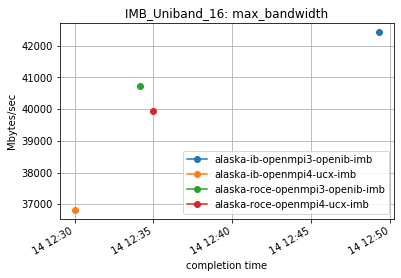

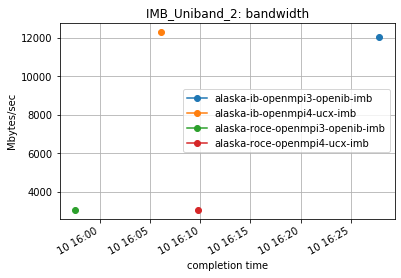

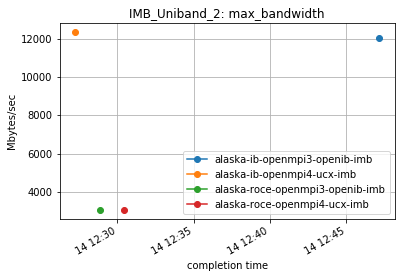

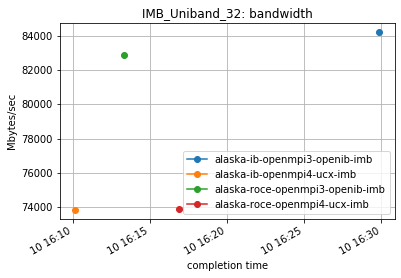

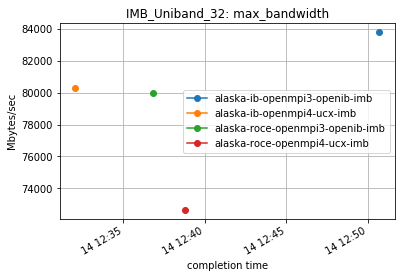

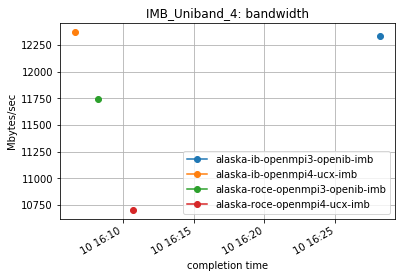

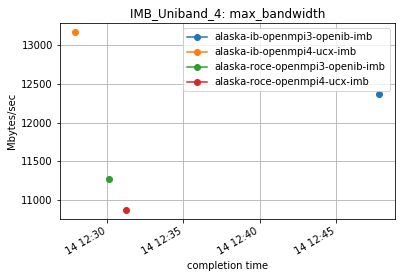

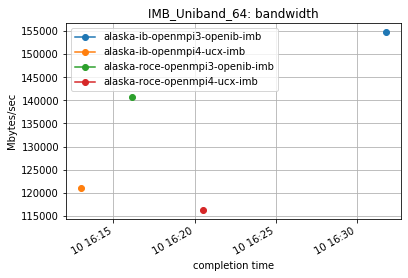

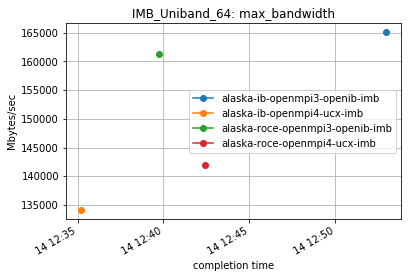

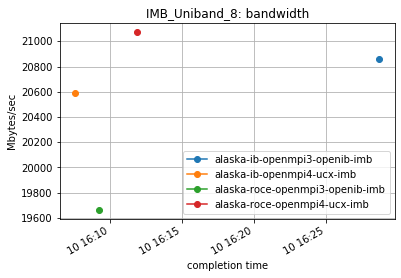

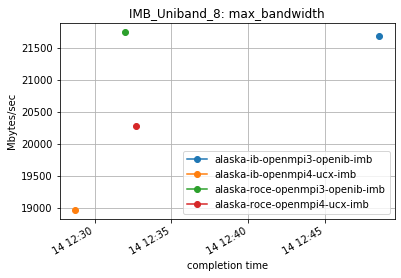

In [4]:
# Plot performance history:
perf_records = modules.utils.load_perf_logs('../perflogs', "IMB_", '.log')
modules.plots.plot_perf_history(perf_records)